Missense variants heatmap
# data_env
Derived from 210303MC-DMS

In [1]:
missense_file = '../data/dms_variants_210303/missense_table.csv'

In [6]:
import itertools
import numpy as np
import pandas as pd
from Bio import Seq
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

In [3]:
# next is to go from a sequence to a heatmap
# requires sequence and position filter

# input
protein = 'K3L'
seq = 'atgCTTgcattttgttattcgttgcccaatgcgggtgatgtaataaagggcagagtatacgagaaggattatgctctatatatttatctttttgactatcctcactttgaagctatcttggcagagagtgttaagatgcatatggatagatatgttgaatatagggataaactggtagggaaaactgtaaaagttaaagtgattagagttgattatacaaaaggatatatagatgtcaattacaaaaggatgtgtagacatcaatag'
mut_pos = [(2,88)]

# get list of codons
seq = seq.upper()
codons = [seq[i:i+3] for i in range(0, len(seq), 3)]

# make df of wt and iupac

mis_df = pd.read_csv(missense_file)

data = {'codon':codons}
df = pd.DataFrame(data)
# merge the two
df = pd.merge(df, mis_df[['codon','aa','mis_var']], how='left', on='codon')

# convert string into list of characters
df.mis_var = df.mis_var.apply(lambda x:list(x))

# create a T/F df based on AA abbreviations
def boolean_df(item_lists, unique_items):# Create empty dict
    bool_dict = {}
    
    # Loop through all the tags
    for i, item in enumerate(unique_items):
        
        # Apply boolean mask
        bool_dict[item] = item_lists.apply(lambda x: item in x)
            
    # Return the results as a dataframe
    return pd.DataFrame(bool_dict)

# + H-K, - D-E, Polar-neutral C-T, Non-polar A-V, Aromatic F-Y, Unique G-P, Stop *
aa_list = ['H','K','R','D','E','C','M','N','Q','S','T','A','I','L','V','F','W','Y','G','P','*']
df2 = boolean_df(df.mis_var, aa_list)
df2 = df2.astype(int)

# replace all "0" with "na"
df2.replace(0,np.nan, inplace=True)

# change all 
mut_pos_list = []
for win in mut_pos:
        mut_pos_list.append(list(range(win[0]-1,win[1])))
mut_pos_list = list(itertools.chain.from_iterable(mut_pos_list))

# change all values not in filter to "na"
df2.loc[~df.index.isin(mut_pos_list)] = np.nan

# add in the wt aa with a value of "2"
df3 = df.join(df2)
for index,row in df3.iterrows():
    wt_aa = row['aa']
    df3.loc[index, wt_aa] = 2

# increase index by 1 for residue position
df3.index = df3.index + 1

# add count of missense variants
df3['variant_sum'] = df3[aa_list].sum(axis=1) - 2 #-2 is b/c wt has value of 2, remove

# convert nonsense variants to 0, color as red in heatmap
df3['*'].replace({1:0},inplace=True)
df3.rename(columns={'*':'STOP'},inplace=True)


# mark sites within 5a of PKR
# select 5a_k3l, 1luz_k3l within 5 of 2a1a
close = [22,23,24,25,27,36,37,38,39,41,44,45,46,47,48,49,50,53,69,70,71,75,76,77,78]
df3['Within 5Å'] = np.where(df.index.isin(close), 3, np.nan)

df3.reset_index(names='position', inplace=True)

In [7]:
# save designed variants as set.pkl
k3l_design_list = []

for index,row in df3.iterrows():
    if 1 < index < 89:
        for aa in row['mis_var']:
            k3l_design_list.append(f"{row['aa']}{index}{aa}")

# get designed set
design_output = '../data/dms_variants_210303/k3l_designed_set.pkl'
with open(design_output, 'wb') as f:
    pickle.dump(set(k3l_design_list), f, protocol=pickle.HIGHEST_PROTOCOL)

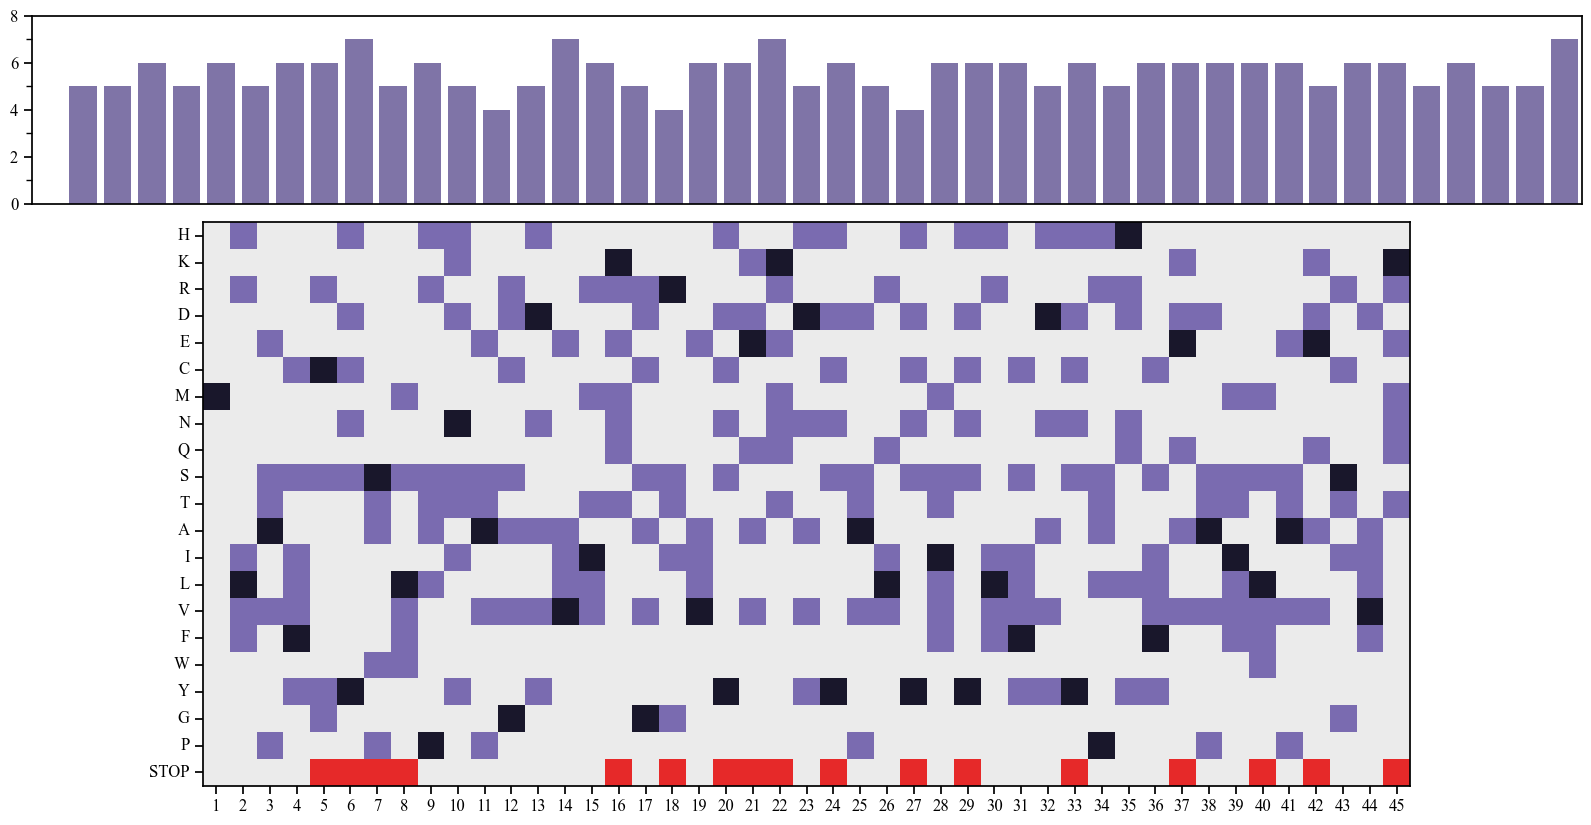

In [44]:
# Set the font size
font = {'family': 'Times New Roman', 'weight': 'normal', 'size': 16}
plt.rc('font', **font)
font_size = 12

# small version
sns.set_context("notebook")
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,10), gridspec_kw={'height_ratios': [1, 3]})
plt.subplots_adjust(wspace=0, hspace=.05)

# barchart
sns.barplot(df3.iloc[:45], x='position', y='variant_sum', palette=['#7a6bb0'], ax=axes[0])
axes[0].set(ylabel=None)
axes[0].yaxis.set_minor_locator(MultipleLocator(1))
axes[0].yaxis.set_major_locator(MultipleLocator(2))
axes[0].yaxis.set_major_formatter('{x:.0f}')
axes[0].set(xticklabels=[])  # remove x labels
axes[0].set(xlabel=None)
axes[0].set_ylim([0,8])
axes[0].tick_params(bottom=False)  # remove the ticks
axes[0].tick_params(axis='both', which='major', labelsize=font_size)  # increase tick label size

# heatmap
aa_list = ['H','K','R','D','E','C','M','N','Q','S','T','A','I','L','V','F','W','Y','G','P','STOP']
data = df3.iloc[:45].set_index('position')[aa_list].T
sns.heatmap(data=data, cmap=['#E62929','#7a6bb0','#19172b'], cbar=False, ax=axes[1], square=True)
for _, spine in axes[1].spines.items():  # frame the heatmap
    spine.set_visible(True)
axes[1].set(xlabel='')
axes[1].tick_params(labelrotation=0)
axes[1].tick_params(which="both", bottom=True)
axes[1].tick_params(axis='both', which='major', labelsize=font_size)  # increase tick label size

axes[1].set_facecolor('#EBEBEB')  # gray the background

fig.savefig(f'../img/dms-heatmap/{protein}-1_design-missense-variants.svg', dpi=300, bbox_inches='tight')

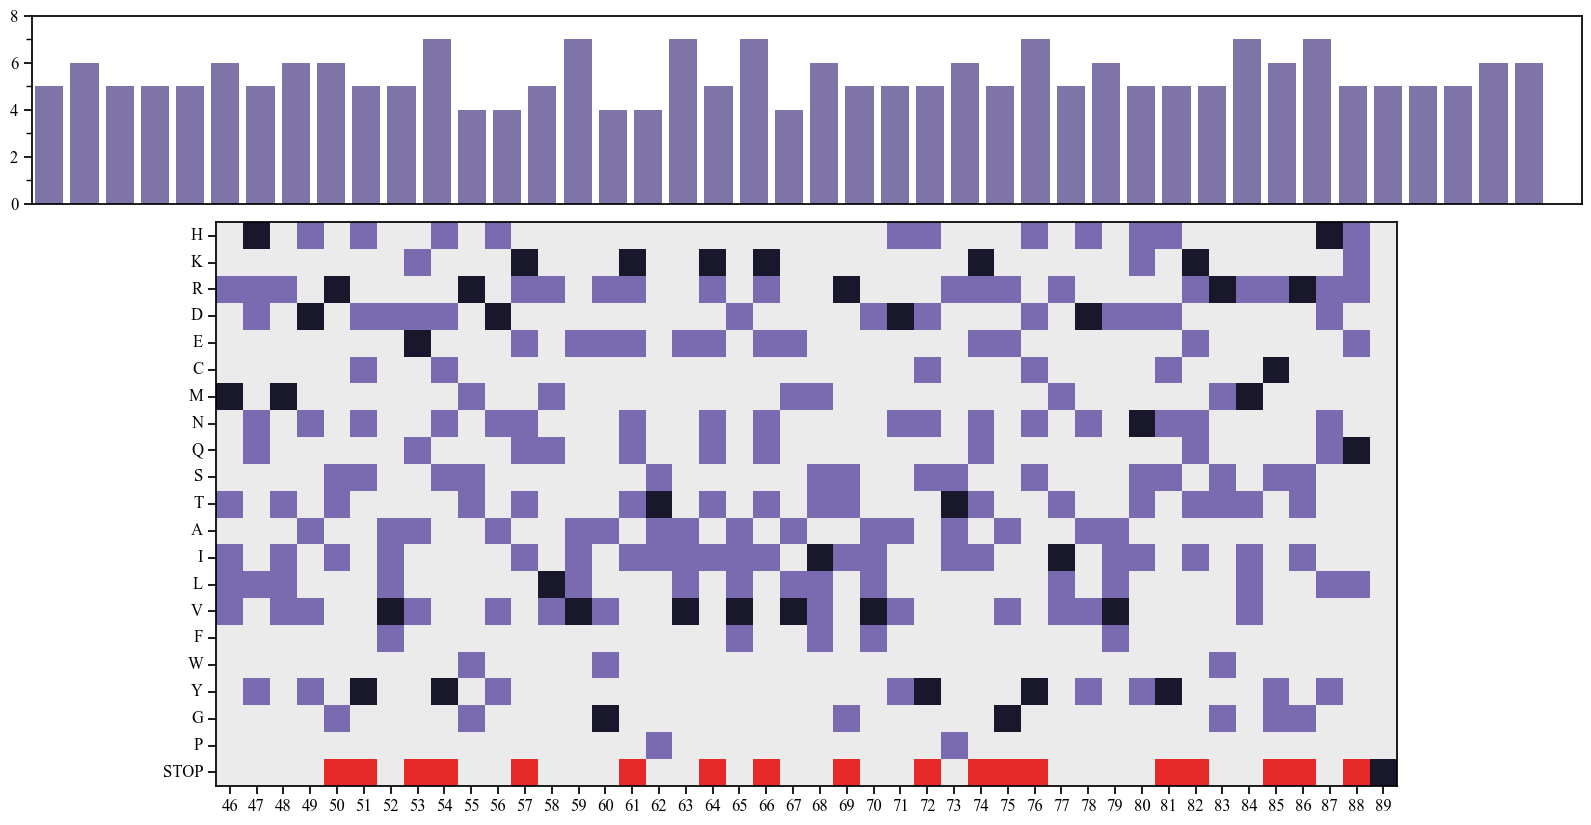

In [43]:
# Set the font size
font = {'family': 'Times New Roman', 'weight': 'normal', 'size': 16}
plt.rc('font', **font)
font_size = 12

# small version
sns.set_context("notebook")
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10), gridspec_kw={'height_ratios': [1, 3]})
plt.subplots_adjust(wspace=0, hspace=.05)

# barchart
sns.barplot(df3.iloc[45:], x='position', y='variant_sum', palette=['#7a6bb0'], ax=axes[0])
axes[0].set(ylabel=None)
axes[0].yaxis.set_minor_locator(MultipleLocator(1))
axes[0].yaxis.set_major_locator(MultipleLocator(2))
axes[0].yaxis.set_major_formatter('{x:.0f}')
axes[0].set(xticklabels=[])  # remove x labels
axes[0].set(xlabel=None)
axes[0].set_ylim([0,8])
axes[0].tick_params(bottom=False)  # remove the ticks
axes[0].tick_params(axis='both', which='major', labelsize=font_size)  # increase tick label size

# heatmap
aa_list = ['H','K','R','D','E','C','M','N','Q','S','T','A','I','L','V','F','W','Y','G','P','STOP']
data = df3.iloc[45:].set_index('position')[aa_list].T
sns.heatmap(data=data, cmap=['#E62929','#7a6bb0','#19172b'], cbar=False, ax=axes[1], square=True)
for _, spine in axes[1].spines.items():  # frame the heatmap
    spine.set_visible(True)
axes[1].set(xlabel='')
axes[1].tick_params(labelrotation=0)
axes[1].tick_params(which="both", bottom=True)
axes[1].tick_params(axis='both', which='major', labelsize=font_size)  # increase tick label size

axes[1].set_facecolor('#EBEBEB')  # gray the background
fig.savefig(f'../img/dms-heatmap/{protein}-2_design-missense-variants.svg', dpi=300, bbox_inches='tight')

In [8]:
# make PKR plot
protein = "PKR"
seq = 'ATGGCTGGTGATCTTTCAGCAGGTTTCTTCATGGAGGAACTTAATACATACCGTCAGAAGCAGGGAGTAGTACTTAAATATCAAGAACTGCCTAATTCAGGACCTCCACATGATAGGAGGTTTACATTTCAAGTTATAATAGATGGAAGAGAATTTCCAGAAGGTGAAGGTAGATCAAAGAAGGAAGCAAAAAATGCCGCAGCCAAATTAGCTGTTGAGATACTTAATAAGGAAAAGAAGGCAGTTAGTCCTTTATTATTGACAACAACGAATTCTTCAGAAGGATTATCCATGGGGAATTACATAGGCCTTATCAATAGAATTGCCCAGAAGAAAAGACTAACTGTAAATTATGAACAGTGTGCATCGGGGGTGCATGGGCCAGAAGGATTTCATTATAAATGCAAAATGGGACAGAAAGAATATAGTATTGGTACAGGTTCTACTAAACAGGAAGCAAAACAATTGGCCGCTAAACTTGCATATCTTCAGATATTATCAGAAGAAACCTCAGTGAAATCTGACTACCTGTCCTCTGGTTCTTTTGCTACTACGTGTGAGTCCCAAAGCAACTCTTTAGTGACCAGCACACTCGCTTCTGAATCATCATCTGAAGGTGACTTCTCAGCAGATACATCAGAGATAAATTCTAACAGTGACAGTTTAAACAGTTCTTCGTTGCTTATGAATGGTCTCAGAAATAATCAAAGGAAGGCAAAAAGATCTTTGGCACCCAGATTTGACCTTCCTGACATGAAAGAAACAAAGTATACTGTGGACAAGAGGTTTGGCATGGATTTTAAAGAAATAGAATTAATTGGCTCAGGTGGATTTGGCCAAGTTTTCAAAGCAAAACACAGAATTGACGGAAAGACTTACGTTATTAAACGTGTTAAATATAATAACGAGAAGGCGGAGCGTGAAGTAAAAGCATTGGCAAAACTTGATCATGTAAATATTGTTCACTACAATGGCTGTTGGGATGGATTTGATTATGATCCTGAGACCAGTGATGATTCTCTTGAGAGCAGTGATTATGATCCTGAGAACAGCAAAAATAGTTCAAGGTCAAAGACTAAGTGCCTTTTCATCCAAATGGAATTCTGTGATAAAGGGACCTTGGAACAATGGATTGAAAAAAGAAGAGGCGAGAAACTAGACAAAGTTTTGGCTTTGGAACTCTTTGAACAAATAACAAAAGGGGTGGATTATATACATTCAAAAAAATTAATTCATAGAGATCTTAAGCCAAGTAATATATTCTTAGTAGATACAAAACAAGTAAAGATTGGAGACTTTGGACTTGTAACATCTCTGAAAAATGATGGAAAGCGAACAAGGAGTAAGGGAACTTTGCGATACATGAGCCCAGAACAGATTTCTTCGCAAGACTATGGAAAGGAAGTGGACCTCTACGCTTTGGGGCTAATTCTTGCTGAACTTCTTCATGTATGTGACACTGCTTTTGAAACATCAAAGTTTTTCACAGACCTACGGGATGGCATCATCTCAGATATATTTGATAAAAAAGAAAAAACTCTTCTACAGAAATTACTCTCAAAGAAACCTGAGGATCGACCTAACACATCTGAAATACTAAGGACCTTGACTGTGTGGAAGAAAAGCCCAGAGAAAAATGAACGACACACATGTTAG'
mut_pos = [(255,278),(371,385),(448,455),(480,506)]

seq = seq.upper()

# get list of codons
codons = [seq[i:i+3] for i in range(0, len(seq), 3)]

# make df of wt and iupac
mis_df = pd.read_csv(missense_file)

data = {'codon':codons}
df = pd.DataFrame(data)
# merge the two
df = pd.merge(df, mis_df[['codon','aa','mis_var']], how='left', on='codon')

# convert string into list of characters
df.mis_var = df.mis_var.apply(lambda x:list(x))

# create a T/F df based on AA abbreviations
def boolean_df(item_lists, unique_items):# Create empty dict
    bool_dict = {}
    
    # Loop through all the tags
    for i, item in enumerate(unique_items):
        
        # Apply boolean mask
        bool_dict[item] = item_lists.apply(lambda x: item in x)
            
    # Return the results as a dataframe
    return pd.DataFrame(bool_dict)

# + H-K, - D-E, Polar-neutral C-T, Non-polar A-V, Aromatic F-Y, Unique G-P, Stop *
aa_list = ['H','K','R','D','E','C','M','N','Q','S','T','A','I','L','V','F','W','Y','G','P','*']
df2 = boolean_df(df.mis_var, aa_list)
df2 = df2.astype(int)

# replace all "0" with "na"
df2.replace(0,np.nan, inplace=True)

# change all 
mut_pos_list = []
for win in mut_pos:
        mut_pos_list.append(list(range(win[0]-1,win[1])))
mut_pos_list = list(itertools.chain.from_iterable(mut_pos_list))

# change all values not in filter to "na"
df2.loc[~df.index.isin(mut_pos_list)] = np.nan

# add in the wt aa with a value of "2"
df3 = df.join(df2)
for index,row in df3.iterrows():
    wt_aa = row['aa']
    df3.loc[index, wt_aa] = 2

# increase index by 1 for residue position
df3.index = df3.index + 1

# add count of missense variants
df3['variant_sum'] = df3[aa_list].sum(axis=1) - 2 #-2 is b/c wt has value of 2, remove

# convert nonsense variants to 0, color as red in heatmap
df3['*'].replace({1:0},inplace=True)
df3.rename(columns={'*':'STOP'},inplace=True)

# mark sites within 5a of PKR
# select 5a_pkr, 2a1a within 5 of 1luz_k3l
close = [276,277,278,337,375,379,382,416,450,451,453,454,485,486,487,488,489,490,491,492,493,496,499]
df3['Within 5Å'] = np.where(df.index.isin(close), 3, np.nan)

# mark sites under positive selection
pos = [255,259,261,275,322,330,336,376,380,461,489,492,496,502,506,516,538]
df3['+ Selection'] = np.where(df.index.isin(pos), 4, np.nan)

# add position column
df3.reset_index(names='position', inplace=True)

In [9]:
df3

,position,codon,aa,mis_var,H,K,R,D,E,C,...,V,F,W,Y,G,P,STOP,variant_sum,Within 5Å,+ Selection
0,1,ATG,M,"[L, V, L, T, R, I]",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
1,2,GCT,A,"[T, P, S, D, V]",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2,3,GGT,G,"[S, R, C, D, A, V]",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,0.0,NaN,NaN
3,4,GAT,D,"[N, H, Y, A, V]",NaN,NaN,NaN,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
4,5,CTT,L,"[I, V, F, H, R]",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547,548,CGA,R,"[G, *, Q, L]",NaN,NaN,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
548,549,CAC,H,"[N, D, Y, R, L, Q]",2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
549,550,ACA,T,"[P, A, S, R, I]",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
550,551,TGT,C,"[S, R, G, Y, S, *]",NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN


In [14]:
mut_pos = [(255,278),(371,385),(448,455),(480,506)]
mut_list = []
for i in mut_pos:
    mut_list = mut_list + list(range(i[0],i[1]+1))
    

# save designed variants as set.pkl
pkr_design_list = []

for index,row in df3.iterrows():
    if index in mut_list:
        for aa in row['mis_var']:
            pkr_design_list.append(f"{row['aa']}{index}{aa}")

# get designed set
design_output = '../data/dms_variants_210303/pkr_designed_set.pkl'
with open(design_output, 'wb') as f:
    pickle.dump(set(pkr_design_list), f, protocol=pickle.HIGHEST_PROTOCOL)

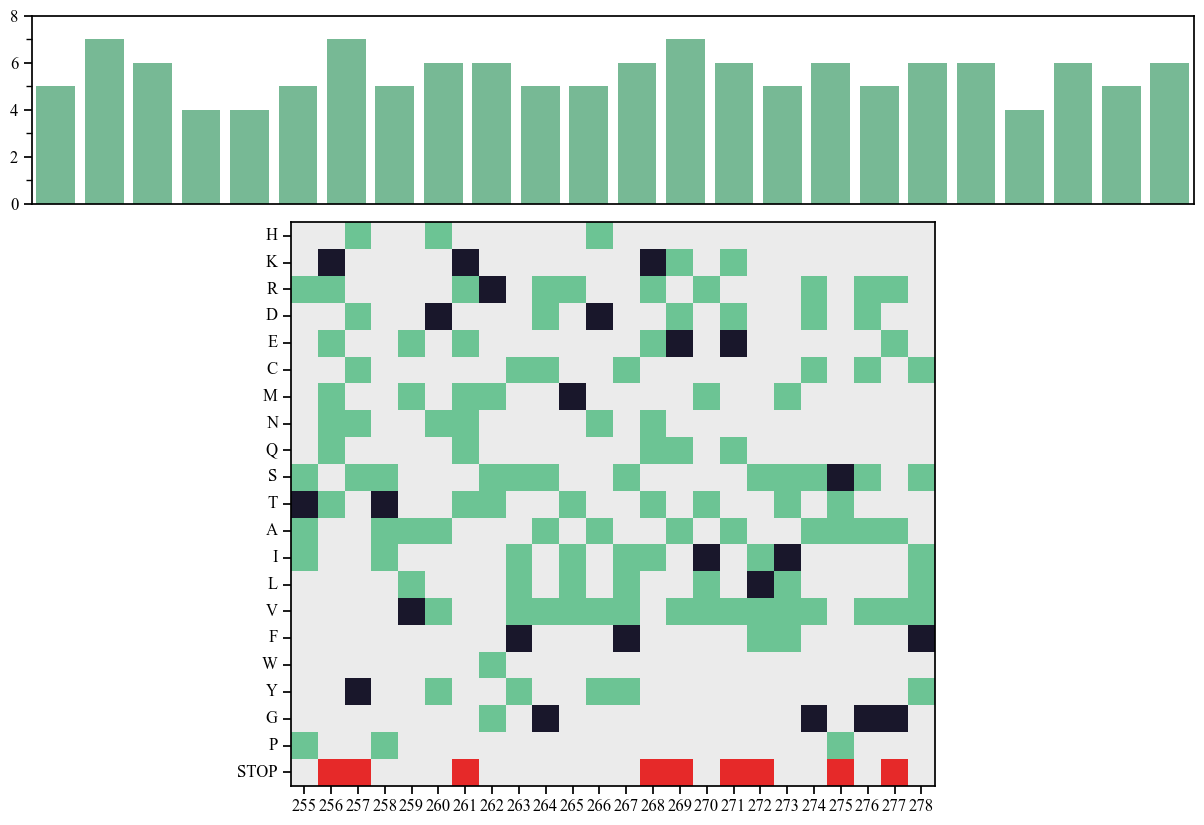

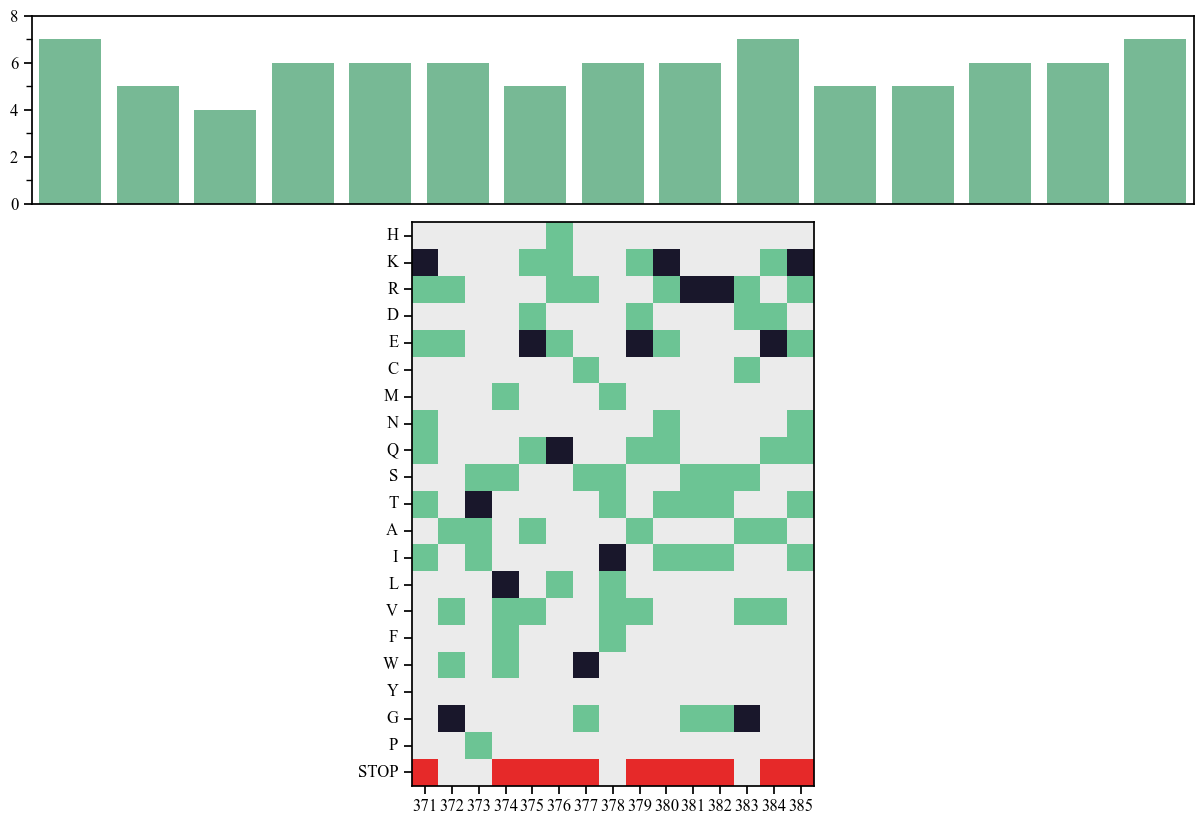

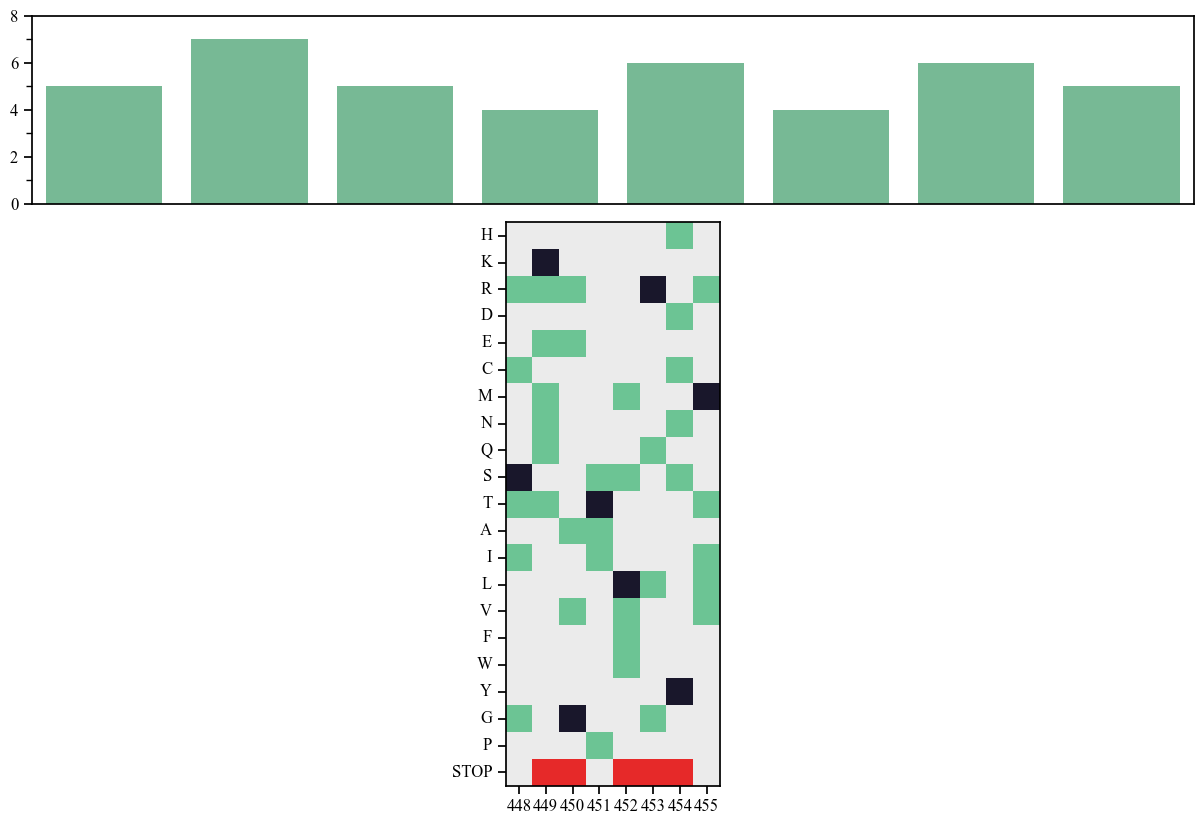

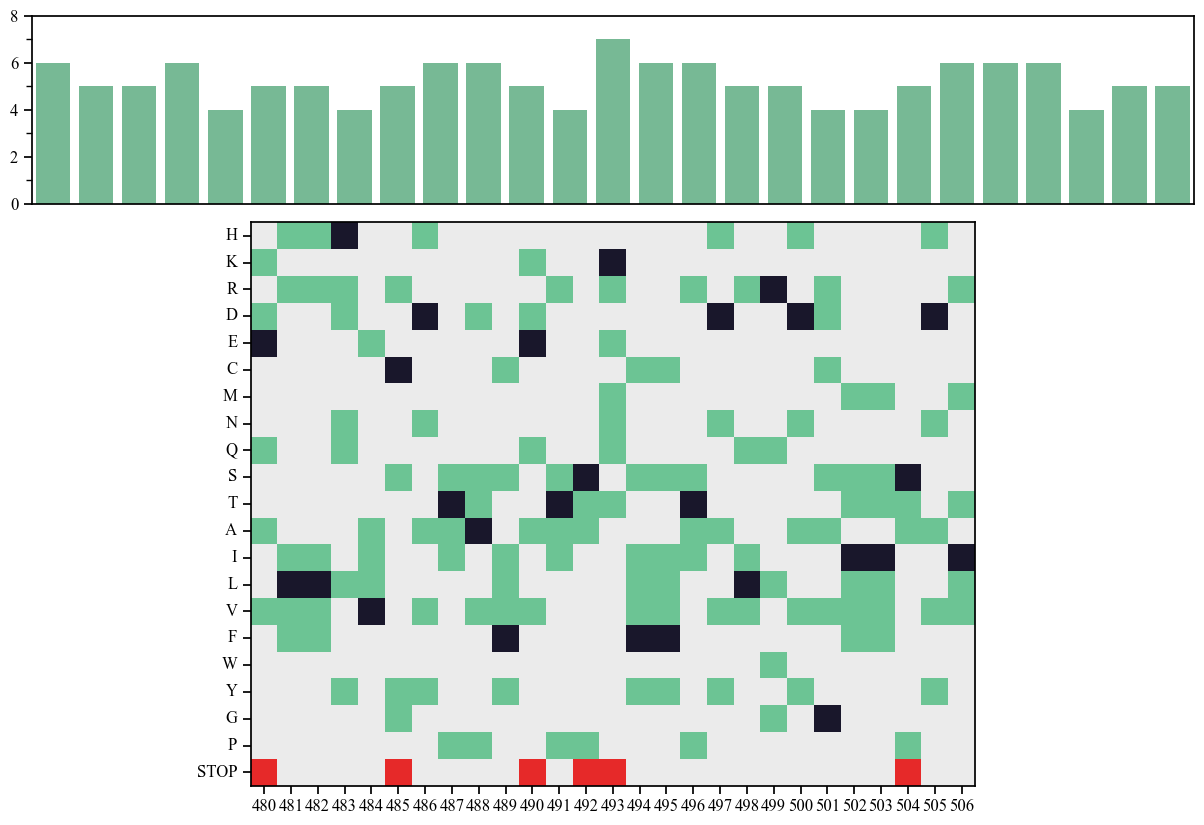

In [34]:
# plot in chunks 
mut_pos = [(255,278),(371,385),(448,455),(480,506)]
aa_list = ['H','K','R','D','E','C','M','N','Q','S','T','A','I','L','V','F','W','Y','G','P','STOP']
font_size = 12

windows = [0,1,2,3]
for win in windows:
    window = mut_pos[win]
    data = df3[df3['position'].isin(list(range(window[0],window[1]+1)))]

    sn.set_context("notebook")
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15,10), gridspec_kw={'height_ratios': [1, 3]})
    plt.subplots_adjust(wspace=0, hspace=.05)

    # barchart
    sn.barplot(data, x='position', y='variant_sum', palette=['#6cc494'], ax=axes[0])
    axes[0].set(ylabel=None)
    axes[0].yaxis.set_minor_locator(MultipleLocator(1))
    axes[0].yaxis.set_major_locator(MultipleLocator(2))
    axes[0].yaxis.set_major_formatter('{x:.0f}')
    axes[0].set(xticklabels=[])  # remove x labels
    axes[0].set(xlabel=None)
    axes[0].tick_params(bottom=False)  # remove the ticks
    axes[0].set_ylim([0,8])
    axes[0].tick_params(axis='both', which='major', labelsize=font_size)
    
    # heatmap [,'#7a6bb0','#19172b']
    sn.heatmap(data=data.set_index('position')[aa_list].T, cmap=['#E62929','#6cc494', '#19172b'], cbar=False, ax=axes[1], square=True)
    for _, spine in axes[1].spines.items(): # frame the heatmap
        spine.set_visible(True)
    axes[1].set(xlabel='')
    axes[1].tick_params(labelrotation=0)
    axes[1].tick_params(which="both", bottom=True)
    axes[1].tick_params(axis='both', which='major', labelsize=font_size)
    
    axes[1].set_facecolor('#EBEBEB')  # gray the background

    fig.savefig(f'../img/dms-heatmap/{protein}-{win+1}.svg', dpi=300, bbox_inches='tight')